In [18]:
import numpy as np
import numpy.linalg as LA
import jax
import jax.numpy as jnp
import jax.numpy.linalg as JLA

import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib

import optax
from tqdm.notebook import trange
from functools import partial
from flax import linen as nn
from flax.experimental import nnx
from flax.training import train_state
from typing import Sequence, Callable, Tuple

In [7]:
class MLP(nn.Module):
    hidden_dim : int
    output_dim : int
    act_fn : Callable = nnx.relu
    
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(self.hidden_dim)(x)
        x = self.act_fn(x)
        x = nn.Dense(self.output_dim)(x)
        return x

In [16]:
T = 4.0
N = 200
eta = T/N
std = 0.1
train_itr = 500
m = 16
init_std = 1e-3
adam_lr = 1e-2

In [30]:
def gen_dataset(std, func):
    x_data = jnp.zeros(N)
    for i in range(N):
        if i % 10 == 0:
            x_data = x_data.at[i].set(func(eta*i) + std*jnp.array(np.random.randn()))
        else:
            x_data = x_data.at[i].set(jnp.nan)
    return x_data

In [25]:
mlp = MLP(hidden_dim=m, output_dim=2)
key = jax.random.PRNGKey(0) 
params = mlp.init(key, x = jnp.zeros(2))["params"]

In [80]:
def Euler(max_itr, params):
    x = jnp.zeros(2)
    for i in range(max_itr):
        x += eta*mlp.apply({"params":params}, x)
    return x[0]

In [73]:
def DU_Euler(x_data, params):
    x = jnp.zeros(2)
    loss = 0.
    for i in range(N):
        x += eta*mlp.apply({"params":params}, x)
        if i % 10 == 0:
            loss += (x[0] - x_data[i])**2
    return loss

In [74]:
tx = optax.adam(learning_rate=adam_lr)
state = train_state.TrainState.create(apply_fn=mlp.apply, params=params, tx=tx)

In [75]:
x_data = gen_dataset(std, jnp.sin)

In [78]:
def step(x_data, state):
    value, grads = jax.value_and_grad(DU_Euler, argnums=-1)(x_data, state.params)
    new_state = state.apply_gradients(grads=grads)
    return value, new_state

def train(state):
    for itr in trange(train_itr, leave=False):
        value, state = step(x_data, state)
        print("\r"+"\rloss:{}".format(value), end=" ")
    return state

In [79]:
trained_state = train(state)

  0%|          | 0/500 [00:00<?, ?it/s]

loss:0.11548112332820892 

In [91]:
df = pd.DataFrame()
df["t"] = jnp.arange(0, T, eta)
df["pred"] = [float(Euler(i, trained_state.params)) for i in range(N)]

In [115]:
df["truth"] = jnp.sin(df["t"].to_numpy())
df["data"] = x_data

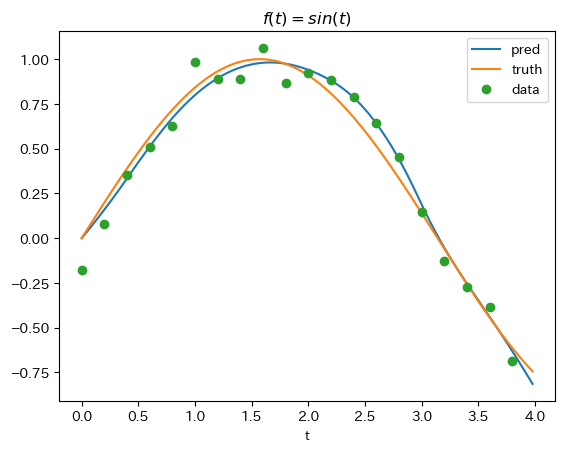

In [119]:
fig, ax = plt.subplots()
df.plot(x = "t", y = df.columns[1:3], ax = ax)
df.plot(x = "t", y = "data", marker= "o", linestyle="", ax = ax)
plt.title("$f(t)=sin(t)$");